In [52]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
stringSST = "300" ##295, 300 or 305
n_days = 25

#TOOCAN segmentation masks (les labels des objets MCS, dans la grille originale x,y,t)
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/TOOCAN_2.07_SAM_RCE_large'+stringSST+'_2D_irtb.nc'

# TOOCAN objects (list d'objets MCS, leur labels et leur caractéristiques)
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/FileTracking/TOOCAN-SAM_RCE_large'+stringSST+'_2D_irtb.dat.gz'

sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [54]:
icon_seg = "/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_01/irtb/TOOCAN_2.07_ICON_large300_2D_irtb.nc"
mesonh_seg = "/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_01/irtb/TOOCAN_2.07_MESONH_large300_2D_irtb.nc"

# Let's Big Data

In [55]:
chunk_size = {'time' :48, 'x' : 32, 'y' : 32}
label_chunk_size = {'time' :48, 'longitude' : 32, 'latitude' : 32}

## Open Precip data un ds

In [56]:
filename = 'dist_SAM_Native_Prec_sizemax_1e7.pkl' # used for import or saving the object
path = '/homedata/mcarenso/distrib/'  # my desired directory path

# Check if the file exists
if os.path.isfile(os.path.join(path, filename)):
    # File exists, load the object
    with open(os.path.join(path, filename), 'rb') as file:
        dist_SAM_Prec = pickle.load(file)
else:
    # File doesn't exist, create the object
    # Create a Dask client
    client = ddistributed.Client()

    # Open native precip datasets
    ds1 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_1.nc", chunks = chunk_size)
    ds2 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_2.nc", chunks = chunk_size)

    # Combine datasets
    ds = xr.concat([ds1, ds2], dim='time')
    # Rename dimensions
    ds["x"] = ((ds["x"])/3e3).astype(int)
    ds["y"] = (ds["y"]/3e3).astype(int) 
    ds["time"] = np.round(((ds["time"]-75)*48)).astype(int)
    ds = ds.isel(time = slice(0, 48*n_days)) 

    dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 6, fill_last_decade=True)
    dist_SAM_Prec.computeDistribution(sample = ds["Prec"].stack(flat=('time', 'y', 'x')).to_numpy())
    dist_SAM_Prec.storeSamplePoints(sample = ds["Prec"].stack(flat=('time', 'y', 'x')).to_numpy(), sizemax = int(1e7))

    # Save the object as a file
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(ds, file)

## Open MCS_list and extract the 6hours 10hours MCS annd pot some of their data distrib

In [57]:
## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
MCS_labels = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file

def idx_by_label(labels, label_list = MCS_labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

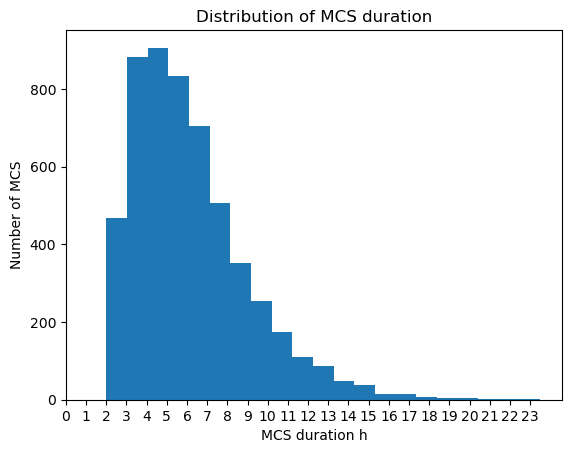

In [58]:
%matplotlib inline
MCS_durations = [MCS[i].duration for i in range(len(MCS))]
# plot the distribution of MCS duration
plt.hist([MCS[i].duration for i in range(len(MCS))], bins = (max(MCS_durations)- min(MCS_durations))//2)

#xticks are half hourly make them hourly
tick_locs = np.arange(0, max(MCS_durations), 2)
tick_labels = np.arange(0, max(MCS_durations),2)//2
plt.xticks(tick_locs, tick_labels)

plt.xlabel("MCS duration h")
plt.ylabel("Number of MCS")
plt.title("Distribution of MCS duration")
plt.show()

In [59]:
MCS_6h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in [11,12,13]]
MCS_6h_labels = [MCS_6h[i].label for i in range(len(MCS_6h))]

MCS_10h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration == 20]
MCS_10h_labels = [MCS_10h[i].label for i in range(len(MCS_10h))]

## Testing

In [60]:
## label_mask contains the label of the MCS over the map
label_mask = xr.open_dataarray(file_seg).isel(time=slice(48*n_days)).chunk(label_chunk_size)

# Put to nan the labels that are not in MCS_6h_labels
label_6h_mask = label_mask.where(label_mask.isin(MCS_6h_labels))

# mask contains the mask True or False if there is an MCS at this position over the map
mask_6h = ~label_6h_mask.where(label_6h_mask.isnull(), False).isnull()

# da contains the native precipitation values over the map filtered where there is an MCS
# Prec = ds["Prec"].where(mask_6h)

In [8]:
# ## TODO : extend to other simulations
# icon_mask = xr.open_dataarray(icon_seg)
# mesonh_mask = xr.open_dataarray(mesonh_seg)

In [61]:
## TODO : read about numpy broadcasting
time_array = np.arange(mask_6h.shape[0])
time_array = np.expand_dims(time_array, axis=tuple(range(1, len(mask_6h.shape))))
time_array = np.where(mask_6h, time_array, np.nan)
time_array = time_array.flatten()

In [62]:
# Define the function to map labels to MCS values and vectorize it
def Age(label, i, MCS=MCS_6h, labels=MCS_6h_labels):
    """MCS and labels must be indexed in the same fashion"""
    if ~np.isnan(label): 
        idx = labels.index(label)
        t = time_array[i]
        time_init = MCS[idx].TimeInit
        duration = MCS[idx].duration
        age = (t - time_init + 2)/duration
        if age == 0:
            print("why")
        return age if age != 0 else np.nan
    else:
        return np.nan
    
def Age_vec(label_mask):
    return np.array([Age(label, i) for i, label in enumerate(label_mask)])

# Apply the function to the label_mask
age_array = Age_vec(label_6h_mask.data.compute().flatten())

In [ ]:
Age_Over_bins = dist_SAM_Prec.computeDataOverBins(sample = ds["Prec"].values, data= age_array, sizemax = int(1e7))

--- 71.69372367858887 seconds for 2nd method which uses array subscriptability ---


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


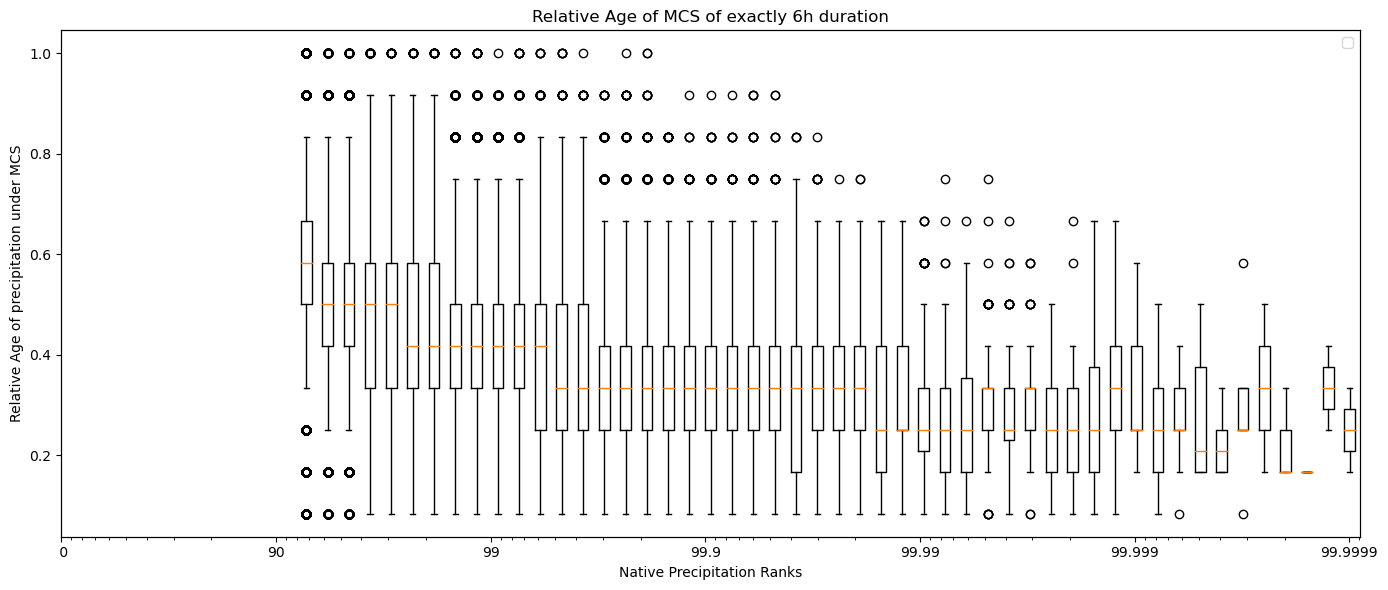

In [ ]:
%matplotlib inline
nrows = 1
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=dist_SAM_Prec.ranks

setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(Age_Over_bins)
ax_show.set_xticks([])

ax.set_xlabel("Native Precipitation Ranks")

ax.set_ylabel("Relative Age of precipitation under MCS")
plt.legend()
plt.title("Relative Age of MCS of exactly 6h duration")
plt.tight_layout()
plt.show()